Found 2 run files.

=== Aggregated Predictive Metrics (mean ± CI) ===
ACC       : 0.9429 ± 0.0019
NLL       : 0.2123 ± 0.0041
ECE       : 0.0476 ± 0.0087
BRIER     : 0.0921 ± 0.0034


/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_21826/3252429311.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  runs = [torch.load(p, map_location="cpu") fo

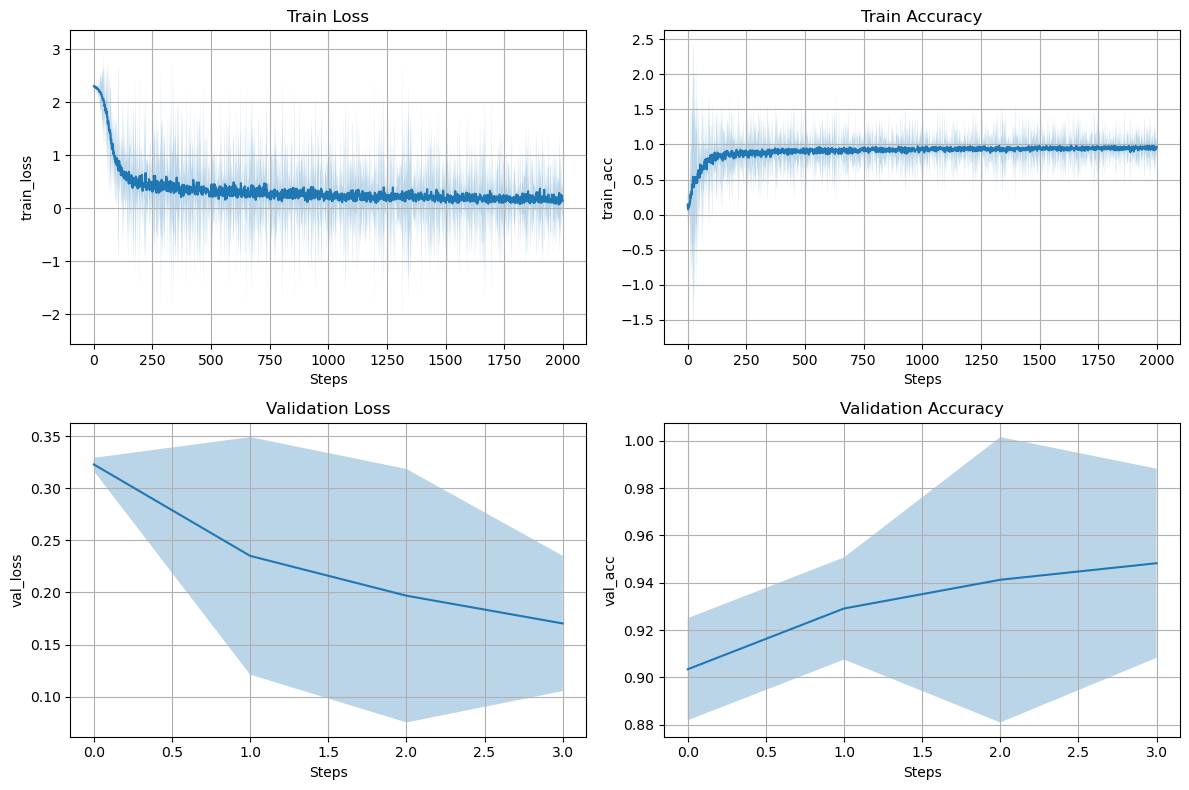


✅ Summary saved to results/summary.json


In [2]:
# %%
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from utils import mean_confidence_interval

# ------------------------
# Config
# ------------------------
results_dir = "./results"
confidence = 0.95
manual_run_paths = [
    "./results/sgld_gaussian_scale1.0_lr0.1_H200_bs100_runs0_20251013-221713.pt",
    "./results/sgld_gaussian_scale1.0_lr0.1_H200_bs100_runs1_20251013-221749.pt"
]

save_summary = True

# ------------------------
# Load runs
# ------------------------
run_paths = manual_run_paths if manual_run_paths is not None else glob(os.path.join(results_dir, "*.pt"))
if len(run_paths) == 0:
    raise ValueError(f"No run files found in {results_dir}")
print(f"Found {len(run_paths)} run files.")

runs = [torch.load(p, map_location="cpu") for p in run_paths]

# ------------------------
# Aggregate predictive metrics
# ------------------------
metric_keys = ["acc", "nll", "ece", "brier"]
agg_metrics = {}

print("\n=== Aggregated Predictive Metrics (mean ± CI) ===")
for k in metric_keys:
    vals = [r["test_metrics"].get(k, np.nan) for r in runs]
    mean, ci = mean_confidence_interval(vals, confidence)
    agg_metrics[k] = {"mean": float(mean), "ci": float(ci)}
    print(f"{k.upper():<10}: {agg_metrics[k]['mean']:.4f} ± {agg_metrics[k]['ci']:.4f}")

# ------------------------
# Aggregate training curves
# ------------------------
history_keys = ["train_loss", "train_acc", "val_loss", "val_acc"]
agg_curves = {}

for key in history_keys:
    min_len = min(len(r["train_val_history"][key]) for r in runs)
    aligned = np.array([r["train_val_history"][key][:min_len] for r in runs])
    mean, ci = mean_confidence_interval(aligned, confidence)
    agg_curves[key] = {"mean": mean, "ci": ci}

# ------------------------
# Plot 2x2 Grid of Curves
# ------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
titles = ["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]

for ax, key, title in zip(axes.flatten(), history_keys, titles):
    mean = agg_curves[key]["mean"]
    ci = agg_curves[key]["ci"]
    steps = np.arange(len(mean))
    ax.plot(steps, mean, label=f"{title}")
    ax.fill_between(steps, mean - ci, mean + ci, alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel("Steps")
    ax.set_ylabel(key)
    ax.grid(True)

plt.tight_layout()
plt.show()

# ------------------------
# Save summary to JSON
# ------------------------
if save_summary:
    os.makedirs(results_dir, exist_ok=True)
    summary = {
        "metrics": agg_metrics,
        "curves": {k: {"mean": agg_curves[k]["mean"].tolist(),
                       "ci": agg_curves[k]["ci"].tolist()} for k in history_keys},
        "run_paths": run_paths
    }
    with open(os.path.join(results_dir, "summary.json"), "w") as f:
        json.dump(summary, f, indent=2)
    print("\n✅ Summary saved to results/summary.json")

